# 1. Load MoonBoard Problem Data

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import copy
from GraphFunctions import *

In [2]:
#Data is taken from https://github.com/jrchang612/MoonBoardRNN
raw_data_path = 'moonGen_scrape_2016_final'
with open(raw_data_path, 'rb') as f:
    MoonBoard_2016_raw = pickle.load(f)
    
#Make holds list of numpy arrays
for key, problem in MoonBoard_2016_raw.items():
    problem['start'] = [np.array(el) for el in problem['start']]
    problem['mid'] = [np.array(el) for el in problem['mid']]
    problem['end'] = [np.array(el) for el in problem['end']]
    
    if len(problem['start']) > 2: #Some problems were transcribed weirdly and have many repeating holds
        problem['start'] = list(np.unique(np.array(problem['start']), axis = 0))
        problem['mid'] = list(np.unique(np.array(problem['mid']), axis = 0))
        problem['end'] = list(np.unique(np.array(problem['end']), axis = 0))

Create a list of problems than have been repeated at least once. Augment the data by creating left-right mirrored versions of each of these climbs, which should have the same difficulty. 

In [3]:
problem_list = []
for key, problem in MoonBoard_2016_raw.items():
    if grade_to_class[problem['grade']] > 0.5 and grade_to_class[problem['grade']] < 10.5 and problem['repeats'] >= 1 and len(problem['start']) <= 2: #<9.5 make V10
        problem['mirrored'] = False
        problem_list += [problem]

        mirrored_problem = copy.deepcopy(problem)
        mirrored_problem['mirrored'] = True
        mirrored_problem['start'] = [np.array([1, -1])*(np.array([10, 0]) - el) for el in mirrored_problem['start']]
        mirrored_problem['mid'] = [np.array([1, -1])*(np.array([10, 0]) - el) for el in mirrored_problem['mid']]
        mirrored_problem['end'] = [np.array([1, -1])*(np.array([10, 0]) - el) for el in mirrored_problem['end']]
        problem_list += [mirrored_problem]
        
print("There are %d climbs with difficulty between V4 and V11 that have been repeated at least once." %len(problem_list))

There are 50140 climbs with difficulty between V4 and V11 that have been repeated at least once.


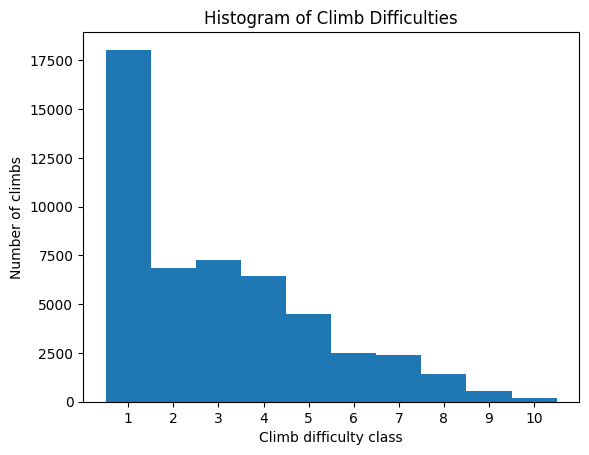

In [4]:
grades = np.zeros(len(problem_list))
for i in range(len(problem_list)):
    grades[i] = grade_to_class[problem_list[i]['grade']]

plt.hist(grades, bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,10.5])
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlim([0, 11])
plt.xlabel("Climb difficulty class")
plt.ylabel("Number of climbs")
plt.title("Histogram of Climb Difficulties")
plt.show()

# 2. Load Moonnboard Hold Data

In [5]:
import pandas as pd

In [6]:
#Read in the data about the difficulty scores and angles of each hold on the board. These difficulty scores were taken by hand
holdDiff = pd.read_csv("holdData.csv")
X_coord, Y_coord, LH, RH, Angle = holdDiff['X_coord'], holdDiff['Y_coord'], holdDiff['Difficulties LH'], holdDiff['Difficulties RH'], holdDiff['Angle']
holdDict = {}
for i in range(len(X_coord)):
    holdDict[(X_coord[i], Y_coord[i])] = {'LH': LH[i], 
                              'RH': RH[i],
                              'Angle': Angle[i]}

In [7]:
#For mirrored climbs, the hold parameters needs to be mirrored as well. 
holdDictMirror = {}
for key, el in holdDict.items():
    holdDictMirror[(10-key[0], key[1])] = {'LH': el['RH'],
                                        'RH': el['LH'],
                                        'Angle': -el['Angle']}

# 3. Make Problems Into Graph

Each problem on the moonboard is defined by a set of holds. The position of a climber, while climbing, can be defined by the position of their left hand and their right hand. From any position, they can move either their left or right hand. I create a graph in which each position, defined by a unique left hand and right hand pair, is a node. Each position, or node, is connected to every other position that requires moving only one hand. The edge value of the connections will later be learned and computed using a MLP model; by default they are initialized to zero. The problemGraph object is equiped to compute the optimal sequence given its edge values.

Initalizing the graphs takes a few minutes because it requires enumerating every possible move for every problem. This including enumarting moves that any climber would know, from the get go, is unrealistic, since I am trying to avoid biasing the algorithm towards any particular sequences. 

In [8]:
graph_list = []
for problem in problem_list:
    if problem['mirrored'] == False:
        graph_list += [problemGraph(problem, holdDict)]
    else:
        graph_list += [problemGraph(problem, holdDictMirror)]

# 4. Define the Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn import metrics
from sklearn.model_selection import train_test_split

In [10]:
class EdgeModel(torch.nn.Module):
    def __init__(self, input_size = 18, num_layers = 3, hidden = 20):
        super(EdgeModel, self).__init__()
        self.relu = torch.nn.ReLU()
        self.lrelu = torch.nn.LeakyReLU(negative_slope=0.0001)

        self.linear_layers = nn.ModuleList()
        self.linear_layers.append(torch.nn.Linear(input_size, hidden))

        for i in range(num_layers):
            self.linear_layers.append(torch.nn.Linear(hidden, hidden))
            
        self.linear_layers.append(torch.nn.Linear(hidden, 100))
        self.linear_layers.append(torch.nn.Linear(100, 10))
        self.linear_layers.append(torch.nn.Linear(10, 1))

    def forward(self, x, masks):

        for i in range(len(self.linear_layers)-1):
            linear = self.linear_layers[i]
            x = (linear(x).permute(2, 0 ,1)*masks).permute(1,2,0)
            x = self.lrelu(x #lrelu helped with consistency and convergence 

        x = (self.linear_layers[-1](x).permute(2, 0 ,1)*masks).permute(1,2,0)
        x = self.relu(x) #This ensures the ouput is strictly positive, since a best can never be so easy that it makes a climb easier. 
        return x

In [11]:
n_resequence = 30 #Number of time to recalculate the optimal sequences for each climb
n_epochs = 100 #Number of training epoch for each set of optimal sequences
batch_size = 256 #The batch size during training

torch.manual_seed(15) #Set the seed for initializing the model for consistency, but does not really matter #15 woorked well
model = EdgeModel(input_size = 18, hidden = 50, num_layers = 3).to(device) #Create the model
optimizer = optim.Adam(model.parameters(), lr= 1e-5, weight_decay= 1) #Create the optimizer with learning rate 1e-5 and L2 regularization constant of 1
loss_fn = nn.MSELoss(reduction = 'mean')  # L2 loss

printModelSummary(model)

EdgeModel(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.0001)
  (linear_layers): ModuleList(
    (0): Linear(in_features=18, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

Total numer of trainable parameters is 14721.


In [12]:
def calc_move_difficulty(moves):
    '''
    Function takes an numpy array of moves and outputs a numpy array of difficulty scores using the MLP model
    '''
    X = torch.from_numpy(moves).type(torch.FloatTensor).to(device)
    return model(X, torch.Tensor([1.]).to(device)).cpu().detach().numpy().squeeze()

def calculate_accuracy(Y_pred, Y_true):
    '''
    Function calculates the accuracy of the predictions made by the model.
    Y_pred is a torch tensor representing the sum of the difficulty score of all of the moves on a climb
    Y_true is a torch tensor representing the target difficulty score of the sum of the moves on a climb
    The output accuracies are all floats
    '''

    y_pred = get_class(Y_pred) #Convert from difficulty score to problem difficulty class
    y_true = get_class(Y_true) #Convert from difficulty score to problem difficulty class

    #Calculate the accuracy
    acc = np.sum(y_pred == y_true)/len(y_pred) #Calculate the accuracy

    #Calculate the accuracy plus or minus one
    y_pred_p1, y_pred_m1 = y_pred + 1, y_pred - 1
    acc_pm1 = (np.sum(y_pred == y_true) + np.sum(y_pred_p1 == y_true) + np.sum(y_pred_m1 == y_true))/len(y_pred)

    #Repeat the calculations, but this time, instead of using font grades use the Heuco V grade system. 
    v_pred = convert_class_to_V_scale(y_pred)
    v_true = convert_class_to_V_scale(y_true)
    
    #Calculate the accuracy of v grades
    acc_v = np.sum(v_pred == v_true)/len(Yp)

    #Calculate the accuracy of v grades plus or minus one
    v_pred_p1, v_pred_m1 = v_pred + 1, v_pred - 1
    acc_v_pm1 = (np.sum(v_pred == v_true) + np.sum(v_pred_p1 == v_true) + np.sum(v_pred_m1 == v_true))/len(Yp)
    
    return acc, acc_pm1, acc_v, acc_v_pm1


def get_class(Y):
    '''Define a function to go from a climb's difficulty score to its numeric class. Takes as an input a torch tensor and returns a numpy array.'''
    return np.round(2*(np.log2(Y.cpu().detach().numpy() + 1e-20)-2)) #Addiing 1e-20 is used to avoid errors in case the a climb's difficulty ever comes up as "0"

def convert_class_to_V_scale(Y):
    '''In the V grades, 6C and 6C+ both correspond to a single class called V5.
    Similarly, 7B and 7B+ both corresponds to a single class called V8. 
    Paper online report the accuracy of their predictions using V grades.
    
    This function returns class label corresponding to V grades instead of font scale. Takes as an input a numpy array and returns a numpy array.'''
    V = np.zeros_like(Y)

    for i in range(len(Y)):
        if Y[i] <= 2:
            V[i] = Y[i]
        elif Y[i] <= 6:
            V[i] = Y[i]-1
        else:
            V[i] = Y[i]-2

    return V

def optimize_sequences(graph_list, in_training = False):
    '''
    Optimizes the sequence of all the graphProblem objects specified in the input graph_list. 

    Then, creates a padded vectorized representations of the sequences for all the problems for rapid inference. 
    These are split into a test/train datasets with the same random state each time, so that even when regenerating the sequences the problems to which they correspond are the same.
    '''
    
    longest_sequence = 0
    for graph in graph_list:
        graph.compute_edges(calc_move_difficulty) #Compute the edge values of each graph using the update move difficulty model
        graph.optimize_sequence() # Then finds the optimal path to traverse it
        if len(graph.optimal_seq) > longest_sequence:
            longest_sequence = len(graph.optimal_seq)

    #Add a print statement if this function is being called in the training loop
    if in_training:
        print("For resequence %d the longest sequence length is %d"%(j, longest_sequence))

    #Create lists of the optimal sequences, the lengths of those sequences, and the grade of the climbs
    X = [] #Sequence
    L = [] #Unpadded sequence length
    Y = [] #Grade class
    
    for graph in graph_list:
        sequence = graph.optimal_moves
        L.append(len(sequence))
        sequence = np.pad(sequence, ((0, longest_sequence-len(sequence)), (0,0)))
        X.append(sequence)
        Y.append(2**(2+grade_to_class[graph.problem['grade']]/2)) #Represent the target difficulty as 2**(2+class/2) (see github readme)

    #Do a train test split with a fixed random state
    X_train, X_test, Y_train, Y_test, L_train, L_test = train_test_split(np.array(X), np.array(Y), np.array(L), test_size=0.2, random_state=42)

    #Cast all the numpy arrays to torch tensors on the appropriate device
    Xt = torch.from_numpy(X_train).type(torch.FloatTensor).to(device)
    Yt = torch.from_numpy(Y_train).type(torch.FloatTensor).to(device)
    Lt = torch.from_numpy(L_train).type(torch.FloatTensor)
    Mask_t = create_mask(Lt, longest_sequence).to(device)
    
    Xtest = torch.from_numpy(X_test).type(torch.FloatTensor).to(device)
    Ytest = torch.from_numpy(Y_test).type(torch.FloatTensor).to(device)
    Ltest = torch.from_numpy(L_test).type(torch.FloatTensor)
    Mask_test = create_mask(Ltest, longest_sequence).to(device)

    return Xt, Yt, Lt, Mask_t, Xtest, Ytest, Ltest, Mask_test

# 4b Train the Model (skip if desired)

In this section, I train the model. If desired, this section can be skipped in favor of 

In [13]:
history_list = [] #Initialize an empty list for the training history. For each resequence, have a single 

In [14]:
for j in range(n_resequence):
    
    # Calculate the optimal sequences for all the problems and create a padded vectorized representations for rapid inference
    Xt, Yt, Lt, Mask_t, Xtest, Ytest, Ltest, Mask_test = optimize_sequences(graph_list, in_training = True)

    #Create a new empty history dictionary for this resequencing iteration
    history = {'loss': np.zeros(n_epochs), 
               'train accuracy': np.zeros(n_epochs),
               'train accuracy pm1': np.zeros(n_epochs),
               'train accuracy v': np.zeros(n_epochs),
               'train accuracy v pm1': np.zeros(n_epochs),
               'test loss': np.zeros(n_epochs), 
               'test accuracy': np.zeros(n_epochs), 
               'test accuracy pm1': np.zeros(n_epochs),
               'test accuracy v': np.zeros(n_epochs),
               'test accuracy v pm1': np.zeros(n_epochs)}

    #For n_epochs
    for epoch in range(n_epochs):
        #Go through the entire dataset with the appropriate batch size
        for i in range(0, len(Y)//batch_size):
            Yp = torch.sum(model(Xt[i*batch_size:(i+1)*batch_size], Mask_t[i*batch_size:(i+1)*batch_size]).squeeze(), axis = 1)
            loss = loss_fn(Yp, Yt[i*batch_size:(i+1)*batch_size]).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #Evaluate the loss and accuracry on the training data and add it this to the history
        Yp = torch.sum(model(Xt, Mask_t).squeeze(), axis = 1)
        
        loss = loss_fn(Yp, Yt).cpu().detach()
        history['loss'][epoch] = loss
        acc, acc_pm1, acc_v, acc_v_pm1 = calculate_accuracy(Yp, Yt)
        
        history['train accuracy'][epoch], history['train accuracy pm1'][epoch] = acc, acc_pm1
        history['train accuracy v'][epoch], history['train accuracy v pm1'][epoch] = acc_v, acc_v_pm1

        #Evaluate the loss and accuracry on the test data and add it this to the history
        Yp = torch.sum(model(Xtest, Mask_test).squeeze(), axis = 1)

        test_loss = loss_fn(Yp, Ytest).cpu().detach()
        history['test loss'][epoch] = test_loss
        
        acc, acc_pm1, acc_v, acc_v_pm1 = calculate_accuracy(Yp, Ytest)
        history['test accuracy'][epoch], history['test accuracy pm1'][epoch] = acc, acc_pm1
        history['test accuracy v'][epoch], history['test accuracy v pm1'][epoch] = acc_v, acc_v_pm1
        
        if epoch%10 == 0:
            print(f'Finished epoch {epoch}, latest loss {loss}, latest test loss {test_loss}')
    
    print(f'Finished epoch {epoch}, latest loss {loss}, latest test loss {test_loss}')

    history_list += [history]

#Optimize the sequences one last time with the final model
Xt, Yt, Lt, Mask_t, Xtest, Ytest, Ltest, Mask_test = optimize_sequences(graph_list)

print("Done!")

For resequence 0 the longest sequence length is 3
Finished epoch 0, latest loss 512.434814453125, latest test loss 506.21197509765625
Finished epoch 10, latest loss 283.1387634277344, latest test loss 277.93548583984375
Finished epoch 20, latest loss 256.6481018066406, latest test loss 251.26211547851562
Finished epoch 30, latest loss 250.65158081054688, latest test loss 245.02159118652344
Finished epoch 40, latest loss 247.49803161621094, latest test loss 241.9044952392578
Finished epoch 50, latest loss 246.0247802734375, latest test loss 240.58656311035156
Finished epoch 60, latest loss 245.1953582763672, latest test loss 239.91275024414062
Finished epoch 70, latest loss 244.62559509277344, latest test loss 239.47308349609375
Finished epoch 80, latest loss 244.19480895996094, latest test loss 239.1424560546875
Finished epoch 90, latest loss 243.81716918945312, latest test loss 238.85067749023438
Finished epoch 99, latest loss 243.52493286132812, latest test loss 238.62709045410156
Fo

In [40]:
#Save the model for future inference use
torch.save(model.state_dict(), "saved_model.pt")

# 5. Plot Convergence Properties

Here I plot the convergence properties of training. We see that as the model for what makes a move difficult is updated, the redetermining the optimal sequences leads to qualitative changes in the convergence properties of the loss and accuracy metrics.

In [41]:
#Create numpy arrays of the resequencing index and the loss/accuracies at the end of each resequencing run 
reseq = np.arange(len(history_list))
loss_test, loss_train, acc_test, acc_test_pm1, acc_train, acc_train_pm1 = np.zeros(len(reseq)), np.zeros(len(reseq)), np.zeros(len(reseq)), np.zeros(len(reseq)), np.zeros(len(reseq)), np.zeros(len(reseq)) 

for i in range(len(history_list)):
    hist = history_list[i]
    loss_train[i] = hist['loss'][-1]
    loss_test[i] = hist['test loss'][-1]
    acc_test[i] = hist['test accuracy v'][-1]
    acc_test_pm1[i] = hist['test accuracy v pm1'][-1]
    acc_train[i] = hist['train accuracy v'][-1]
    acc_train_pm1[i] = hist['train accuracy v pm1'][-1]

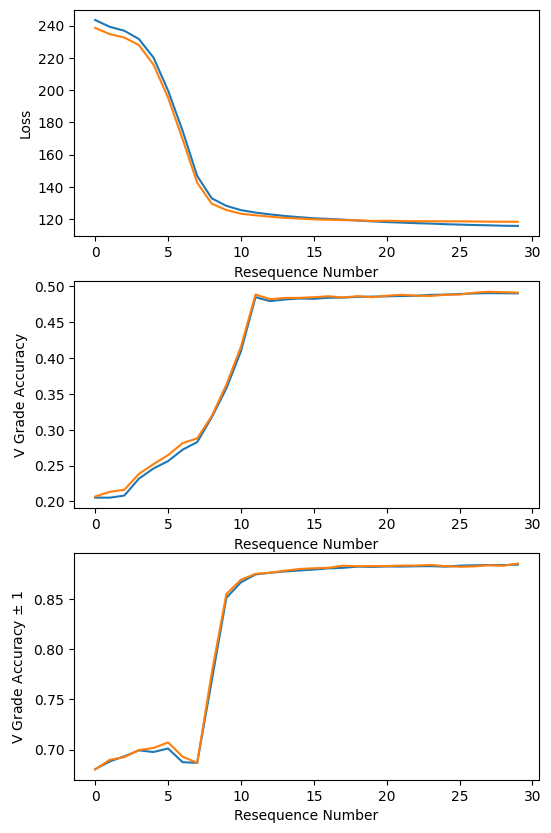

In [56]:
plt.figure(figsize=(6,10))

plt1, plt2, plt3 = plt.subplot(311), plt.subplot(312), plt.subplot(313)

plt1.plot(reseq, loss_train)
plt1.plot(reseq, loss_test)
plt1.set_xlabel("Resequence Number")
plt1.set_ylabel("Loss")

plt2.plot(reseq, acc_train)
plt2.plot(reseq, acc_test)
plt2.set_xlabel("Resequence Number")
plt2.set_ylabel("V Grade Accuracy")

plt3.plot(reseq, acc_train_pm1)
plt3.plot(reseq, acc_test_pm1)
plt3.set_xlabel("Resequence Number")
plt3.set_ylabel("V Grade Accuracy $\pm$ 1")

plt.show()

# 6. Evaluating Determined Sequences

Here I show some of the predicted optimal sequences for a handful of climbs. The outputs shown are a list of arrays with 4 elements. The first two correspond to the x and y position of the left hand hold, and the last two correspond to the x and y position of the right hand. 

For example, the consider following sequence with two positions: [[ 0  4  3  5], [ 0  8  3  5]]. The first position corresponds to having your left hand on the hold at (x=0, y=4) and right hand on the hold at (x=3, y=5). The first position corresponds to having your left hand on the hold at (x=0, y=8) and right hand on the hold at (x=3, y=5). So, overall, from the first position to the second you have moved your left hand from (x=0, y=4) to (x=0, y=8). Sequences are represented this way until both hands are on the finish hold(s). Note that the position in this notebook are zero indexed. In the linked pictures of problems, the y position is one indexed and the x position is given a letter instead of a number. A mental conversion needs to be applied for the two to correspond.

Overall,the predicted sequences are very reasonable for a range of problems of varying difficulties! The algorith learned that the smaller moves are optimal, and that in most situations alternating between left and right hand movements is best. Furthermore, it even manages to learn that sometimes, you want to do several left hand or right hand moves in a row in certain situations.

In [ ]:
# # If not retraining the model from scratch, load the saved model and recompute the optimal sequences.

# model.load_state_dict(torch.load("saved_model.pt"))
# model.eval()

# #Calculate the optimal sequences for all the problems and create a padded vectorized representations for rapid inference
# Xt, Yt, Lt, Mask_t, Xtest, Ytest, Ltest, Mask_test = optimize_sequences(graph_list)

In [29]:
#Predicts a reasonable classic LH RH alternating sequence
problem_index = 0
print("Problem font grade: ", graph_list[problem_index].problem['grade'])
print("Link to picture of problem: ", graph_list[problem_index].problem['url'])
print("Predicted optimal sequence: \n", graph_list[problem_index].optimal_seq)

Problem font grade:  6C
Link to picture of problem:  https://moonboard.com/Problems/View/367892/cats-are-furry-children
Predicted optimal sequence: 
 [[ 0  4  3  5]
 [ 0  8  3  5]
 [ 0  8  4  8]
 [ 2 12  4  8]
 [ 2 12  3 14]
 [ 0 17  3 14]
 [ 0 17  0 17]]


In [30]:
#Predicts a reasonable sequence, where it does two realistic left hand moves in a row.
problem_index = 25164
print("Problem font grade: ", graph_list[problem_index].problem['grade'])
print("Link to picture of problem: ", graph_list[problem_index].problem['url'])
print("Predicted optimal sequence: \n", graph_list[problem_index].optimal_seq)

Problem font grade:  6C
Link to picture of problem:  https://moonboard.com/Problems/View/314508/bz-hyperion
Predicted optimal sequence: 
 [[10  4 10  4]
 [ 9  7 10  4]
 [ 9  7  8 10]
 [ 4 10  8 10]
 [ 4 10  3 11]
 [ 2 13  3 11]
 [ 1 15  3 11]
 [ 1 15  4 17]
 [ 4 17  4 17]]


In [31]:
#Predicts a reasonable sequence, where it does two realistic left hand moves in a row.
problem_index = 37046
print("Problem font grade: ", graph_list[problem_index].problem['grade'])
print("Link to picture of problem: ", graph_list[problem_index].problem['url'])
print("Predicted optimal sequence: \n", graph_list[problem_index].optimal_seq)

Problem font grade:  7C
Link to picture of problem:  https://moonboard.com/Problems/View/254625/f%C3%BCr-immer-mein
Predicted optimal sequence: 
 [[ 7  4  7  4]
 [ 7  4  6  9]
 [ 3  9  6  9]
 [ 2 14  6  9]
 [ 2 14  2 17]
 [ 2 17  2 17]]


In [32]:
#Predicts a reasonable sequence, though matching hands on (4,7) is unnecessary
problem_index = 40550
print("Problem font grade: ", graph_list[problem_index].problem['grade'])
print("Link to picture of problem: ", graph_list[problem_index].problem['url'])
print("Predicted optimal sequence: \n", graph_list[problem_index].optimal_seq)

Problem font grade:  7B+
Link to picture of problem:  https://moonboard.com/Problems/View/191609/capitanbogli
Predicted optimal sequence: 
 [[10  4 10  4]
 [ 4  7 10  4]
 [ 4  7  4  7]
 [ 4  7  6 10]
 [ 2 14  6 10]
 [ 2 14  6 17]
 [ 6 17  6 17]]


In [33]:
#Predicts a slightly strange sequence, electing to skip the hold at (1,10).
problem_index = 41780
print("Problem font grade: ", graph_list[problem_index].problem['grade'])
print("Link to picture of problem: ", graph_list[problem_index].problem['url'])
print("Predicted optimal sequence: \n", graph_list[problem_index].optimal_seq)

Problem font grade:  6B+
Link to picture of problem:  https://moonboard.com/Problems/View/170190/saluhallen-6
Predicted optimal sequence: 
 [[ 4  5  7  4]
 [ 4  5  6  8]
 [ 6  8  6  8]
 [ 6 12  6  8]
 [ 6 12  6 12]
 [ 4 14  6 12]
 [ 4 14  8 17]
 [ 8 17  8 17]]


In [58]:
#Predicts a reasonable sequence
problem_index = 23610
print("Problem font grade: ", graph_list[problem_index].problem['grade'])
print("Link to picture of problem: ", graph_list[problem_index].problem['url'])
print("Predicted optimal sequence: \n", graph_list[problem_index].optimal_seq)

Problem font grade:  7C+
Link to picture of problem:  https://moonboard.com/Problems/View/322940/ghost-town
Predicted optimal sequence: 
 [[ 3  5  7  4]
 [ 3  5  8  7]
 [ 4 10  8  7]
 [ 4 10  7 15]
 [ 7 17  7 15]
 [ 7 17  7 17]]


In [35]:
#Predicts a reasonable sequence
problem_index = 33798
print("Problem font grade: ", graph_list[problem_index].problem['grade'])
print("Link to picture of problem: ", graph_list[problem_index].problem['url'])
print("Predicted optimal sequence: \n", graph_list[problem_index].optimal_seq)

Problem font grade:  7A+
Link to picture of problem:  https://moonboard.com/Problems/View/305656/tjockis
Predicted optimal sequence: 
 [[ 5  4  5  4]
 [ 2  9  5  4]
 [ 2  9  7 11]
 [ 5 13  7 11]
 [ 5 13 10 17]
 [10 17 10 17]]


In [36]:
#Predicts a reasonable sequence
problem_index = 30200
print("Problem font grade: ", graph_list[problem_index].problem['grade'])
print("Link to picture of problem: ", graph_list[problem_index].problem['url'])
print("Predicted optimal sequence: \n", graph_list[problem_index].optimal_seq)

Problem font grade:  6B+
Link to picture of problem:  https://moonboard.com/Problems/View/308058/maggie-s-problem
Predicted optimal sequence: 
 [[ 6  1 10  4]
 [ 9  7 10  4]
 [ 9  7 10  8]
 [ 7 11 10  8]
 [ 7 11  8 13]
 [ 4 14  8 13]
 [ 4 14  4 17]
 [ 4 17  4 17]]


# 7. Classification Accuracy Analysis

The V-grade classification accuracy of the model slightly outperforms that which was reported in https://arxiv.org/pdf/2102.01788. They reported test/dev set accuracies of around 47% and +/-1 accuracies of 85%. Here, I get 49% and 88%. 

In [25]:
Yp = torch.sum(model(Xt, Mask_t).squeeze(), axis = 1)

_, _, acc_v, acc_v_pm1 = calculate_accuracy(Yp, Yt)

print("Train V accuracy: ", acc_v)
print("Train V accuracy pm1: ", acc_v_pm1)

print("\n-------------------------------------------------\n")

Yp = torch.sum(model(Xtest, Mask_test).squeeze(), axis = 1)

_, _, acc_v, acc_v_pm1 = calculate_accuracy(Yp, Ytest)

print("Test V accuracy: ", acc_v)
print("Test V accuracy pm1: ", acc_v_pm1)

Train V accuracy:  0.49000299162345434
Train V accuracy pm1:  0.8840496609493419

-------------------------------------------------

Test V accuracy:  0.49102512963701633
Test V accuracy pm1:  0.8851216593538094


The confusion matrix shows that my algorithm more accurately predicts the difficulty of lower grade climbs, similarly to the reslts reported in https://arxiv.org/pdf/2102.01788.

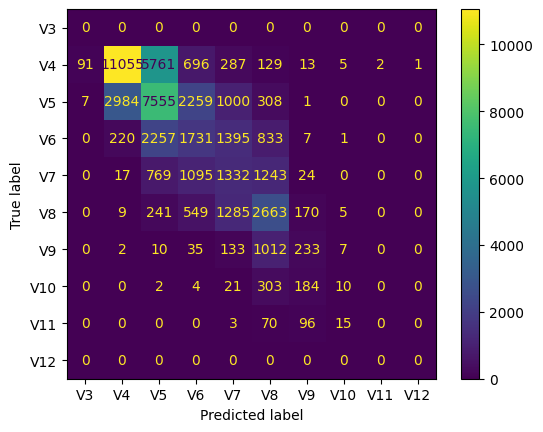

In [26]:
Yp1 = torch.sum(model(Xt, Mask_t).squeeze(), axis = 1)
Yp2 = torch.sum(model(Xtest, Mask_test).squeeze(), axis = 1)

predicted = np.concatenate((convert_class_to_V_scale(get_class(Yp1)),convert_class_to_V_scale(get_class(Yp2))))
actual = np.concatenate((convert_class_to_V_scale(get_class(Yt)),convert_class_to_V_scale(get_class(Ytest))))
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12']) #
cm_display.plot()
plt.show()